***
# Clustering
MSDS 7331-407, Lab 3 
*Jenna Ford, Edward Fry, Christian Nava, and Jonathan Tan* 
***

## Table of Contents

<a href='#Section_1'> 1. Business Understanding </a>  
<a href='#Section_2'> 2. Preparation and Dataset Loading </a>  
<a href='#Section_3'> 3. Data Understanding </a>  
<a href='#Section_3_a'> &nbsp;&nbsp;&nbsp;&nbsp; a. Data Meaning </a>  
<a href='#Section_3_b'> &nbsp;&nbsp;&nbsp;&nbsp; b. Visualize Attributes </a>  
<a href='#Section_4'> 4. Modeling and Evaluation </a>  
<a href='#Section_5'> 5. Deployment </a>  
<a href='#Section_6'> 6. Exceptional Work </a>  

<a id = 'Section_1'></a>

## 1. Business Understanding

*(10 points)*

*Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?*

<a id = 'Section_2'></a>

## 2. Preparation and Dataset Loading

In [1]:
# Data manipulation
import numpy as np
import pandas as pd
import sklearn
from pandas import DataFrame
import seaborn as sn
import seaborn as sns
import pylab as plt

# Creating training and test sets
import sklearn

# File system management
import os.path

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

In [3]:
DATA_SOURCE="./diabetic_data.csv"

df_raw = pd.read_csv(DATA_SOURCE)

df = df_raw
print("The dataset has {:,} rows and {:,} columns".format(*df.shape))

The dataset has 101,766 rows and 50 columns


<a id = 'Section_3'></a>

## 3. Data Understanding

<a id = 'Section_3_a'></a>

### a. Data Meaning

*(10 points)* 

*Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?*

| Feature Name | Type | Description and Values |
|:---|:---|:---|
| encounter_id | Numeric | Unique identifier of an encounter |
| patient_nbr | Numeric | Unique identifier of a patient |
| race | Nominal | Values: Caucasian, Asian, African American, Hispanic, and other |
| gender | Nominal | Values: male, female, and unknown/invalid |
| age | Nominal | Grouped in 10-year intervals: 0-10, 10-20, ..., 90-100 |
| weight | Numeric | Weight in pounds |
| admission_type_id | Nominal | Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available |
| discharge_disposition_id | Nominal | Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available |
| admission_source_id | Nominal | Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from a hospital |
| time_in_hospital | Numeric | Integer number of days between admission and discharge |
| payer_code | Nominal | Integer identifier corresponding to 23 distinct values, for example, Blue Cross\Blue Shield, Medicare, and self-pay |
|medical_specialty | Nominal | Integer identifier of a specialty of the admitting physician, corresponding to 84 distinct values, for example, cardiology, internal medicine, family\general practice, and surgeon |
| num_lab_procedures | Numeric | Number of lab tests performed during the encounter |
| num_procedures | Numeric | Number of procedures (other than lab tests) performed during the encounter |
| num_medications | Numeric | Number of distinct generic names administered during the encounter |
| number_outpatient | Numeric | Number of outpatient visits of the patient in the year preceding the encounter |
| number_emergency | Numeric | Number of emergency visits of the patient in the year preceding the encounter |
| number_inpatient | Numeric | Number of inpatient visits of the patient in the year preceding the encounter |
| diag_1 | Nominal | The primary diagnosis (coded as first three digits of ICD9); 848 distinct values |
| diag_2 | Nominal | Secondary diagnosis (coded as first three digits of ICD9); 923 distinct values |
| diag_3 | Nominal | Additional secondary diagnosis (coded as first three digits of ICD9); 954 distinct values |
| number_diagnoses | Numeric | Number of diagnoses entered to the system |
| max_glu_serum | Nominal | Indicates the range of the result or if the test was not taken. Values: “>200,” “>300,” “normal,” and “none” if not measured |
| A1Cresult | Nominal | Indicates the range of the result or if the test was not taken. Values: “>8” if the result was greater than 8%, “>7” if the result was greater than 7% but less than 8%, “normal” if the result was less than 7%, and “none” if not measured |
| change | Nominal | Indicates if there was a change in diabetic medications (either dosage or generic name). Values: “change” and “no change” |
| diabetesMed | Nominal | Indicates if there was any diabetic medication prescribed. Values: “yes” and “no” |
| 24 features for medications | Nominal | For the generic names: metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, sitagliptin, insulin, glyburide-metformin, glipizide-metformin, glimepiride-pioglitazone, metformin-rosiglitazone, and metformin-pioglitazone, the feature indicates whether the drug was prescribed or there was a change in the dosage. Values: “up” if the dosage was increased during the encounter, “down” if the dosage was decreased, “steady” if the dosage did not change, and “no” if the drug was not prescribed |
| readmitted | Nominal | Days to inpatient readmission. Values: “<30” if the patient was readmitted in less than 30 days, “>30” if the patient was readmitted in more than 30 days, and “No” for no record of readmission. |

NEED A FORMAT FOR THIS CITATION

Source: TY - JOUR
TI - Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records
VL - 2014
PY - 2014
DA - 2014/04/03
DO - 10.1155/2014/781670
UR - https://doi.org/10.1155/2014/781670
JF - BioMed Research International
SN - 2314-6133
PB - Hindawi Publishing Corporation
SP - 781670
A2 - Rizvi, Ali
AU - Strack, Beata
AU - DeShazo, Jonathan P.
AU - Gennings, Chris
AU - Olmo, Juan L.
AU - Ventura, Sebastian
AU - Cios, Krzysztof J.
AU - Clore, John N.

|Admission Type ID| Description | 
|:---|:---|
|1| Emergency | 
|2| Urgent | 
|3| Elective |
|4| Newborn |
|5| Not Available | 
|6| NULL |
|7| Trauma Center |
|8| Not Mapped | 

|Discharge Disposition|Description|
|:---|:---|
|1| discharged to home|
|2| discharged/transferred to short term hospital|
|3| discharged/transferred to SNF (skilled nursing facility)|
|4| discharged/transferred to ICF (intermediate care facility)|
|5| discharged/transferred to another type of inpatient care institution|
|6| discharged/transferred to home with home health service|
|7| left AMA (against medical advice)|
|8| discharged/transferred to home under care of Home IV provider (intravenous care/therapy)|
|9| admitted as inpatient to receiving hospital |
|10| neonate discharged to another hospital for neonatal aftercare|
|12| expired|
|13| still patient/expected to return for outpatient services|
|14| hospice/home|
|15| hospice/medical facility|
|16| discharged/transferred within institution to medicare approved swing bed|
|17| discharged/transferred/referred another institution for outpatient services|
|18| NULL |
|19| expired at home, medicaid only, hospice|
|20|  expired in a medical facility, medicate only, hospice|
|21| expired, place unknown, medicaid only, hospice|
|22| discharged/transferred to another rehab facility including rehab units of a hospital|
|23| discharged/transferred to a long term care facility |
|24| discharged/transferred to a nursing facility certified under medicaid but not medicare |
|25| not mapped |
|26| discharged/transferred to an undefined health care facility|
|27| discharged/transferred to a federal health care facility|
|28| discharged/transferred/referred to a psychiatric hospital or psychiatric unit of hospital |
|29| discharged/transferred to CAH (critical access hospital) |

| Admission Source ID | Description |
|:---|:---|
|1| physician referral |
|2| clinic referral|
|3| HMO referral|
|4| transfer from a hospital|
|5| transfer from SNF (skilled nursing facility) |
|6| transfer from another health care facility |
|7| ER |
|8| court/law enforcement |
|9| not available |
|10| transfer from CAH (critical access hospital) |
|11| normal delivery |
|12| premature delivery |
|13| sick baby |
|14| extramural birth |
|15| not available |
|16| NULL transfer | 
|17| from another home health agency |
|18| readmission to same home health agency |
|19|  not mapped |
|20| unknown/invalid |
|21| transfer from hostpital inpatient/same facility resulting in separate claim |
|22| born inside this hospital |
|23| born outside this hospital |
|24| transfer from ambulatory surgery center|
|25| transfer from hospice |

### Duplicated Data

In [4]:
df.duplicated().sum()

0

In [5]:
#HOW MANY PATIENTS APPEAR IN THE DATASET MORE THAN ONCE?
df['patient_nbr'].duplicated().sum()

30248

### Drop Columns that will not be Used

In [6]:
#drop columns that aren't relevant or we aren't going to use
#we can use number_diagnoses in place of diag_1, diag_2, diag_3
df.drop(['encounter_id','patient_nbr','diag_1','diag_2','diag_3'], axis=1, inplace=True)

#for now drop the medication columns to shrink the dataset
df.drop(['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide','citoglipton','insulin','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone'], axis=1, inplace=True)

### Missing Data

In [7]:
df = df.replace('?', np.nan)
df = df.replace('None', np.nan)

In [8]:
df.head()

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,...,1,0,0,0,1,NaN,NaN,No,No,NO
1,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,...,18,0,0,0,9,NaN,NaN,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,...,13,2,0,1,6,NaN,NaN,No,Yes,NO
3,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,...,16,0,0,0,7,NaN,NaN,Ch,Yes,NO
4,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,...,8,0,0,0,5,NaN,NaN,Ch,Yes,NO


In [9]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis = 1, keys = ['Missing Values', '% of Total  Values'])

Need to drop weight, since 96.86% of the values are missing.
Drop rows where payer_code is missing, still leaves us with enough data.
Need to drop medical_specialty because not enough records are left after dropping rows where payer_code is missing.

In [10]:
missing_data(df)

,Missing Values,% of Total Values
weight,98569,96.858479
max_glu_serum,96420,94.746772
A1Cresult,84748,83.277322
medical_specialty,49949,49.082208
payer_code,40256,39.557416
race,2273,2.233555
gender,0,0.000000
age,0,0.000000
admission_type_id,0,0.000000
discharge_disposition_id,0,0.000000


In [11]:
df.drop(['weight','medical_specialty','max_glu_serum','A1Cresult'], axis=1, inplace=True)

In [12]:
df.dropna(subset=['payer_code','race'], axis=0, inplace=True)

In [13]:
missing_data(df)

,Missing Values,% of Total Values
readmitted,0,0.0
diabetesMed,0,0.0
gender,0,0.0
age,0,0.0
admission_type_id,0,0.0
discharge_disposition_id,0,0.0
admission_source_id,0,0.0
time_in_hospital,0,0.0
payer_code,0,0.0
num_lab_procedures,0,0.0


### Prepare Dataset for Clustering

In [14]:
#target variable
target = {"readmitted": {"NO": 0, "<30": 1, ">30": 2}}
df.replace(target,inplace=True)

In [15]:
#create a function to count by column and display percentages
def count_percent(data,field):
    df_grouped = data.groupby(by=field)
    c1 = (df_grouped[field].count())

    c2  = []#create empty list to store percentages
    for x in c1:
        c2.append("{:.2%}".format((x/sum(c1)))) #row value divided by total, formatted as percent, store in list
    c1 = pd.DataFrame(c1) #needs dataframe to start with, then can add new column from list c2
    c1['Percent']= c2
    c1.columns = ['Count','Percent']
    return c1

In [16]:
count_percent(df,'age')

,Count,Percent
age,,
[0-10),13,0.02%
[10-20),220,0.37%
[20-30),1006,1.68%
[30-40),2045,3.42%
[40-50),5376,8.99%
[50-60),9696,16.22%
[60-70),13219,22.11%
[70-80),15080,25.23%
[80-90),11186,18.71%


In [17]:
df['age_num'] = df['age'].astype(str).str[1]
df.drop(['age'], axis=1, inplace=True)

In [18]:
#onehot encoding for variables with 2 categories
#this dataset to be used with K-MODES
df['IsMale'] = df.gender=='Male' 
df.IsMale = df.IsMale.astype(np.int)
df.drop(['gender'], axis=1, inplace=True)

df['med_change'] = df.change=='Ch'
df.med_change = df.med_change.astype(np.int)
df.drop(['change'], axis=1, inplace=True)

df['med_diabetes'] = df.diabetesMed=='Yes'
df.med_diabetes = df.med_diabetes.astype(np.int)
df.drop(['diabetesMed'], axis=1, inplace=True)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59781 entries, 20446 to 101764
Data columns (total 18 columns):
race                        59781 non-null object
admission_type_id           59781 non-null int64
discharge_disposition_id    59781 non-null int64
admission_source_id         59781 non-null int64
time_in_hospital            59781 non-null int64
payer_code                  59781 non-null object
num_lab_procedures          59781 non-null int64
num_procedures              59781 non-null int64
num_medications             59781 non-null int64
number_outpatient           59781 non-null int64
number_emergency            59781 non-null int64
number_inpatient            59781 non-null int64
number_diagnoses            59781 non-null int64
readmitted                  59781 non-null int64
age_num                     59781 non-null object
IsMale                      59781 non-null int32
med_change                  59781 non-null int32
med_diabetes                59781 non-null int32
d

In [20]:
df.head()

,race,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted,age_num,IsMale,med_change,med_diabetes
20446,Caucasian,1,22,7,7,MC,58,2,15,0,0,0,9,0,7,0,1,1
20737,Caucasian,2,1,1,3,MC,59,3,11,0,0,0,6,0,6,0,0,1
20824,Caucasian,1,1,7,4,MC,56,1,9,0,0,0,6,0,9,0,0,1
21083,Caucasian,1,2,7,10,MC,68,1,18,0,0,0,6,0,7,1,1,1
23668,Caucasian,2,1,1,4,MC,33,0,11,0,0,0,4,1,6,0,1,1


In [21]:
#create new dataset to be used with distance based clustering algorithms
df_imputed = df

In [22]:
#onehot encoding for variables with more than 2 categories
tmp_df = pd.get_dummies(df_imputed.race,prefix='race')
df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe
df_imputed.drop(['race'], axis=1, inplace=True)

tmp_df = pd.get_dummies(df_imputed.payer_code,prefix='payer')
df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe
df_imputed.drop(['payer_code'], axis=1, inplace=True)

tmp_df = pd.get_dummies(df_imputed.admission_type_id,prefix='admission_type')
df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe
df_imputed.drop(['admission_type_id'], axis=1, inplace=True)

tmp_df = pd.get_dummies(df_imputed.discharge_disposition_id,prefix='discharge')
df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe
df_imputed.drop(['discharge_disposition_id'], axis=1, inplace=True)

tmp_df = pd.get_dummies(df_imputed.admission_source_id,prefix='admission_source')
df_imputed = pd.concat((df_imputed,tmp_df),axis=1) # add back into the dataframe
df_imputed.drop(['admission_source_id'], axis=1, inplace=True)

In [23]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59781 entries, 20446 to 101764
Data columns (total 81 columns):
time_in_hospital        59781 non-null int64
num_lab_procedures      59781 non-null int64
num_procedures          59781 non-null int64
num_medications         59781 non-null int64
number_outpatient       59781 non-null int64
number_emergency        59781 non-null int64
number_inpatient        59781 non-null int64
number_diagnoses        59781 non-null int64
readmitted              59781 non-null int64
age_num                 59781 non-null object
IsMale                  59781 non-null int32
med_change              59781 non-null int32
med_diabetes            59781 non-null int32
race_AfricanAmerican    59781 non-null uint8
race_Asian              59781 non-null uint8
race_Caucasian          59781 non-null uint8
race_Hispanic           59781 non-null uint8
race_Other              59781 non-null uint8
payer_BC                59781 non-null uint8
payer_CH                59781 

In [24]:
df.head(10)

,race,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted,age_num,IsMale,med_change,med_diabetes
20446,Caucasian,1,22,7,7,MC,58,2,15,0,0,0,9,0,7,0,1,1
20737,Caucasian,2,1,1,3,MC,59,3,11,0,0,0,6,0,6,0,0,1
20824,Caucasian,1,1,7,4,MC,56,1,9,0,0,0,6,0,9,0,0,1
21083,Caucasian,1,2,7,10,MC,68,1,18,0,0,0,6,0,7,1,1,1
23668,Caucasian,2,1,1,4,MC,33,0,11,0,0,0,4,1,6,0,1,1
23701,Caucasian,1,6,7,8,MD,71,0,17,0,0,0,8,0,5,0,1,1
23871,Caucasian,1,1,1,1,HM,38,0,2,0,0,0,5,2,4,1,0,1
23879,Caucasian,1,3,6,12,UN,77,5,19,0,0,0,5,0,7,0,0,1
23922,Caucasian,1,3,6,12,MC,60,5,10,0,0,0,5,0,7,1,0,0
23927,AfricanAmerican,1,3,7,7,MC,52,1,7,0,0,0,7,0,8,1,0,1


In [25]:
print("The dataset has {:,} rows and {:,} columns".format(*df.shape))

The dataset has 59,781 rows and 18 columns


<a id = 'Section_3_b'></a>

### b. Visualize Attributes

*(10 points)*

*Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.*

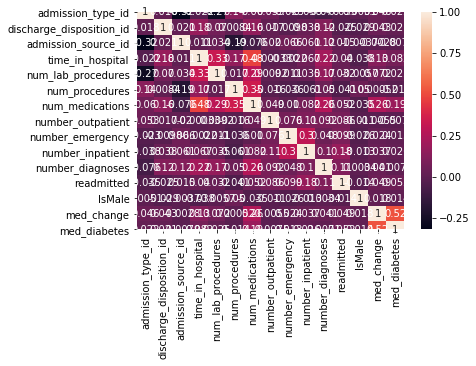

In [26]:
correlation1 = df.corr()
sn.heatmap(correlation1, annot = True)

correlation values
patient number and encounter id - .51 correlation, not useful, only tells us that patient numbers and encounters were generated side by side frequently

number of medications and time in hospital - .47, makes sense, longer hospital stay would result in more medication 

num_medications and number of procedures - .39, same logic

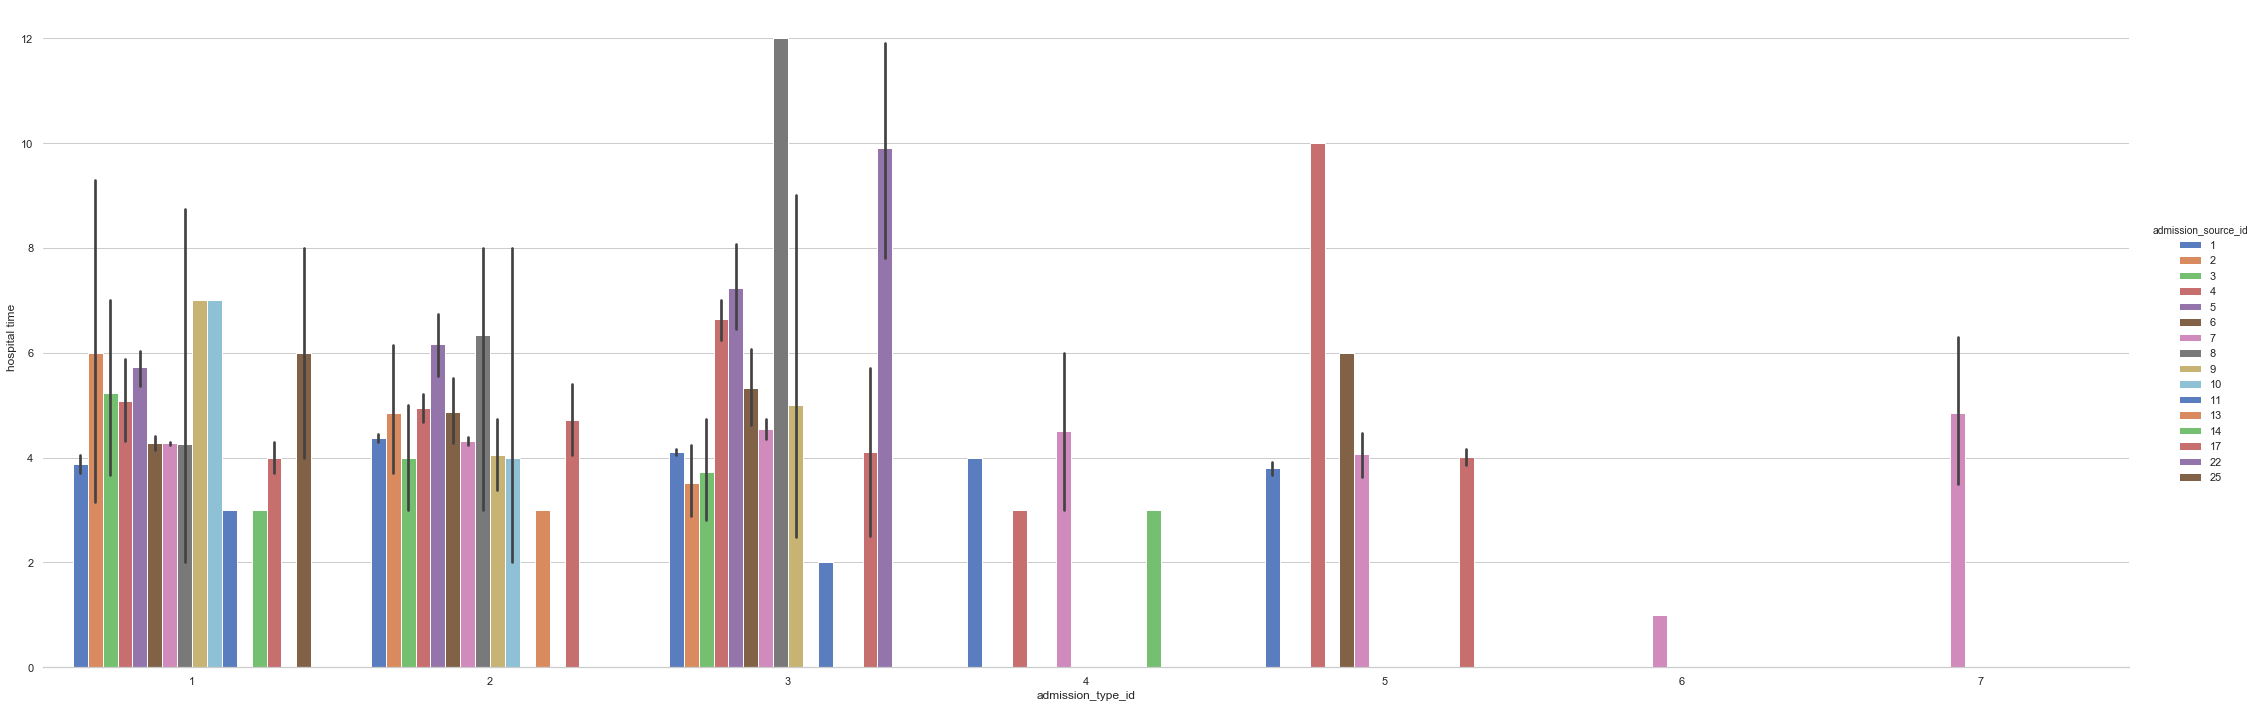

In [27]:
sns.set(style="whitegrid")

v1 = sns.catplot(x="admission_type_id", y="time_in_hospital", hue="admission_source_id", data=df,
                height=10, aspect = 3, kind="bar", palette="muted")
v1.despine(left=True)
v1.set_ylabels("hospital time")

Admission type 1 = Emergency admission has the most datapoints, wide variety of admission sources, largest admission category is "not available", with a hospital stay of 7 days (no whisker? indicating no stays in the category over 7 days?), perhaps indicating a wide variety of miscellaneous sources that dont fall into other categories. Patients with emergency admission from a CAH(critical admission hospital) and from a hospice have outliers that are the longest stays. 

Admission type 2 = Urgent's largest category of admissions is from court/law enforcement, but not by much. 

Admission type 3 = Elective type hospital admissions had a larger plurality sourced from courts/law enforcement, followed by SNF transfers (skilled nursing facility).

Admission type 4 = Newborn, understandably far fewer sources for newborns, only from sources 1, 4, 7, 14; physician, hospital transfer, ER, and extramural birth, respectively. Average stays for this admission type are noticably lower than other admission types. 

Admission type 5 = Not available, difficult to draw conclusions here, only used for sources 1, 4, 6, 7, 17; physician recommendation, hospital transfer, from another healthcare facility, ER, from another home health agency\

Admission type 6 = NULL, ???

Admission type 7 = Trauma Center, exclusively transfers from ER, average stay of 5 days. 

Admission type 8 = Not mapped, ??? 

<Figure size 1152x504 with 0 Axes>

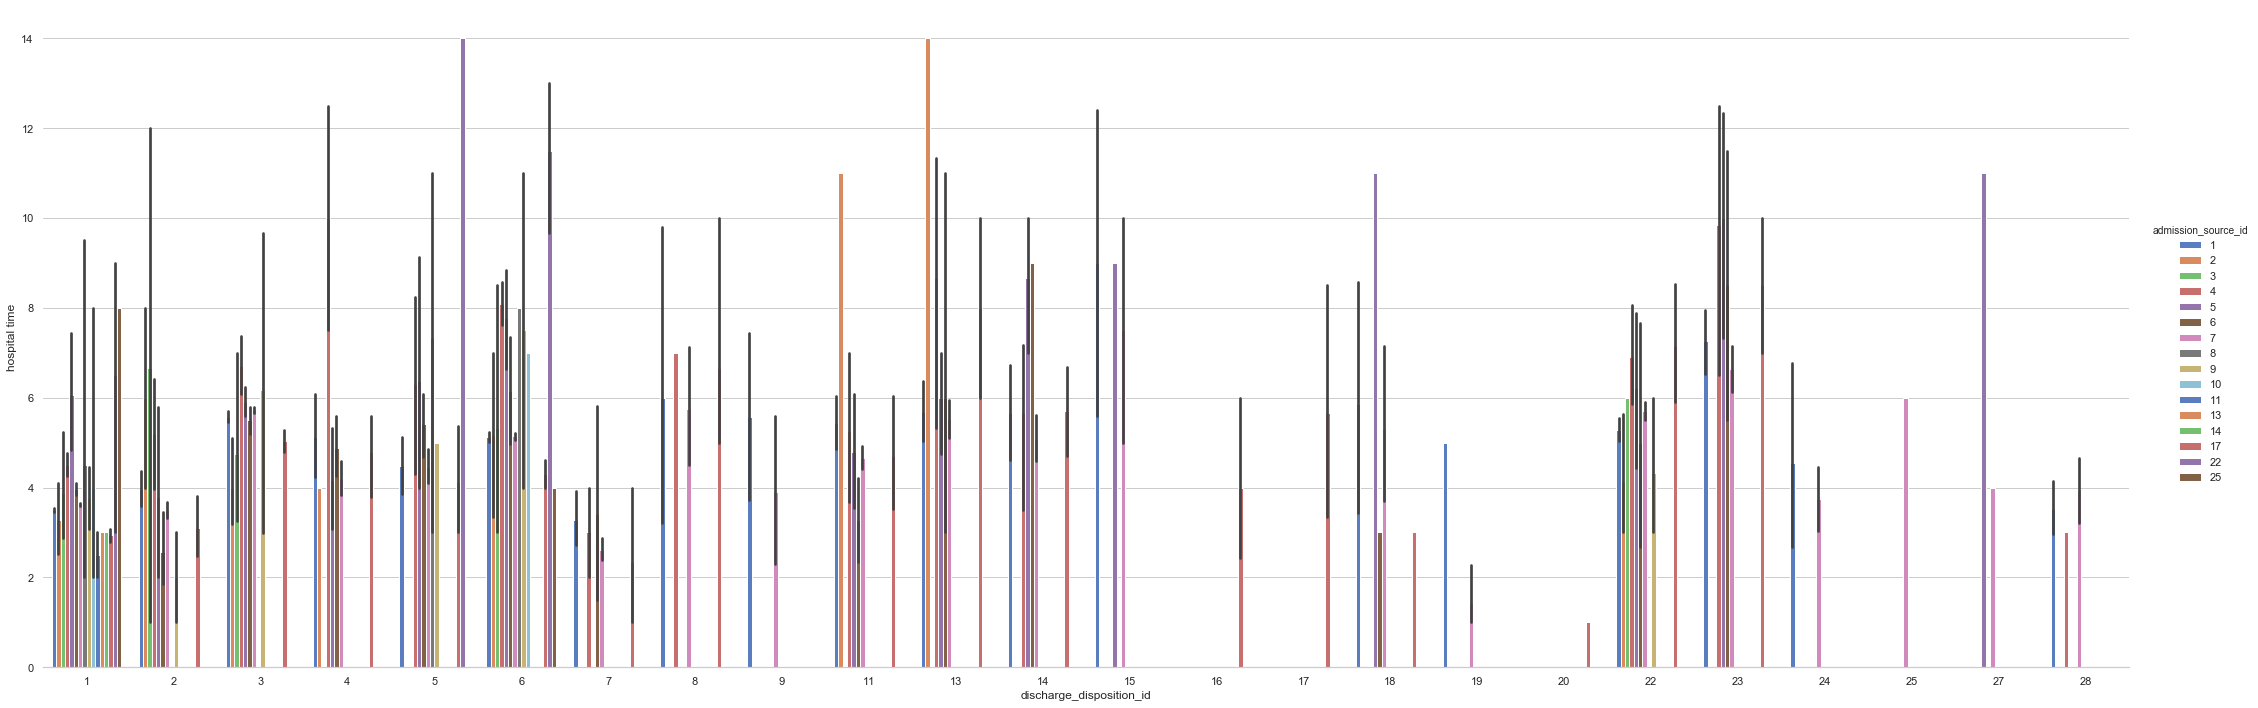

In [28]:
sns.set(style="whitegrid")
plt.figure(figsize = (16, 7)) 
v2 = sns.catplot(x="discharge_disposition_id", y="time_in_hospital", hue="admission_source_id", data=df,
                height=10, aspect = 3, kind="bar", palette="muted")
v2.despine(left=True)
v2.set_ylabels("hospital time")

(this might be too much data to easily analyze, maybe split by discharge disposition?)

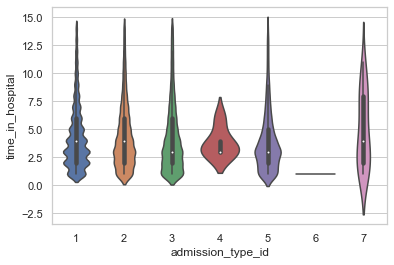

In [29]:
sns.violinplot(x="admission_type_id",y="time_in_hospital",data=df)

most skew around 2.5 days? admission type 7, trauma center, somehow has negative hospital stay duration???

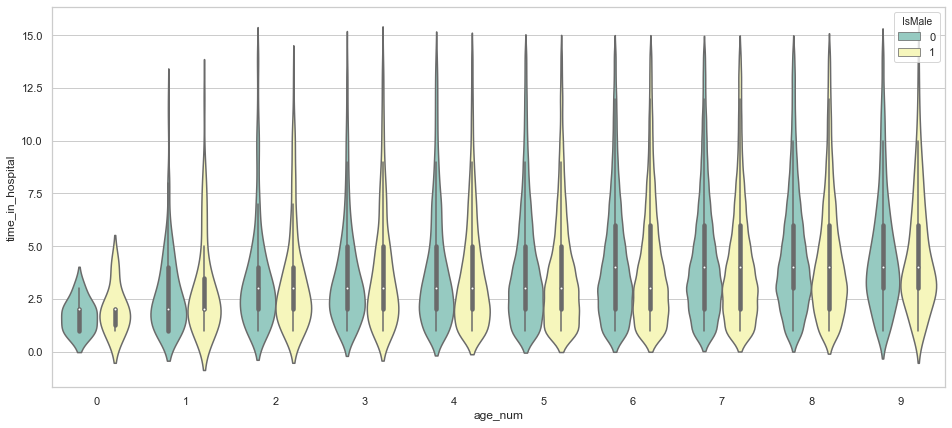

In [34]:
plt.figure(figsize = (16, 7)) 
sns.violinplot(x="age_num",y="time_in_hospital",hue='IsMale',data=df, palette="Set3")

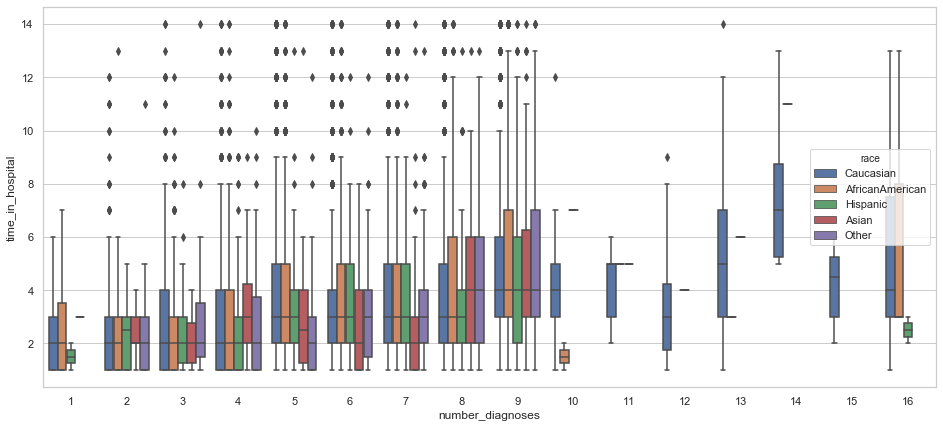

In [36]:
plt.figure(figsize = (16, 7))           
v4 =sns.boxplot(x = "number_diagnoses", y = "time_in_hospital", hue = 'race', data = df)

<a id = 'Section_4'></a>

## 4. Modeling and Evaluation

*(50 points)*

*Different tasks will require different evaluation methods. Be as thorough as possible when analyzing the data you have chosen and use visualizations of the results to explain the performance and expected outcomes whenever possible. Guide the reader through your analysis with plenty of discussion of the results.*

*Option A: Cluster Analysis*

* *Perform cluster analysis using several clustering methods*
* *How did you determine a suitable number of clusters for each method?*
* *Use internal and/or external validation measures to describe and compare the clusterings and the clusters (some visual methods would be good).*
* *Describe your results. What findings are the most interesting and why?*

<a id = 'Section_5'></a>

## 5. Deployment

*(10 points)*

*Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?*
* *How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?*
* *How would your deploy your model for interested parties?*
* *What other data should be collected?*
* *How often would the model need to be updated, etc.?*

<a id = 'Section_6'></a>

## 6. Exceptional Work

*(10 points)*

*You have free reign to provide additional analyses or combine analyses.*